# Lab 10, Aleksandr Berezutskii, group 4, Skoltech 2018

In [1]:
import numpy as np
from matplotlib import pyplot as plt

The objective of this laboratory work is to develop Extended Kalman filter for tracking a moving
object when measurements and motion model are in different coordinate systems. This will bring
about a deeper understanding of main difficulties of practical Kalman filter implementation for
nonlinear models.

Let's first generate a true trajectory $X_i$ of an object motion disturbed by normally distributed random acceleration

$$
x_i = x_{i-1} + v_{i-1}^x T + \frac{a_{i-1}^x T^2}{2}
$$

$$
v_{i}^x = v_{i-1}^x + a_{i-1}^x T
$$

$$
y_i = y_{i-1} + v_{i-1}^y T + \frac{a_{i-1}^y T^2}{2}
$$

$$
v_{i}^y = v_{i-1}^y + a_{i-1}^y T
$$

Initial conditions to generate trajectory:

1. Size is $N=500$ points
2. Interval between measurements $T=1$
3. Initial coordinates: $x_0 = 1000$ and $y_0 = 1000$
4. Initial components of velocity $\vec{v}$: $v_0^x = v_0^y = 10$
5. Variance of noise $a_i$ distribution $\sigma_a^2 = 0.3^2$ for both $x$ and $y$ components

In [3]:
#N is the size of trajectory
N = 500

#T is the interval between measurements
T = 1

#Noise of acceleration
sigma_a = 0.3
a_x = np.random.normal(loc=0.0, scale=sigma_a, size=N)
a_y = np.random.normal(loc=0.0, scale=sigma_a, size=N)

#Now let's create the trajectory
x = np.zeros(N)
x[0] = 1000

y = np.zeros(N)
y[0] = 1000

v_x = np.zeros(N)
v_x[0] = 10

v_y = np.zeros(N)
v_y[0] = 10

for i in range(1,N):
    x[i] = x[i-1] + v_x[i-1]*T + a_x[i-1]*(T**2)/2
    v_x[i] = v_x[i-1] + a_x[i-1]*T
    y[i] = y[i-1] + v_y[i-1]*T + a_y[i-1]*(T**2)/2
    v_y[i] = v_y[i-1] + a_y[i-1]*T

We will now also calculate true values of range $D$ and azimuth $\beta$:

$$
D_i = \sqrt{x_i^2 + y_i^2}
$$

$$
\beta_i = arctg \frac{x_i}{y_i}
$$

In [4]:
D = np.zeros(N)
B = np.zeros(N)

for i in range(N):
    D[i] = (x[i]**2 + y[i]**2) ** 0.5
    B[i] = np.arctan(x[i] / y[i])

Now we will generate measurements $D^m$ and $\beta^m$ of range $D$ and azimuth $\beta$:

$$
D_i^m = D_i + \eta_i^D
$$

$$
\beta_i^m = \beta_i + \eta_i^\beta
$$

Where $\eta$'s are random Gaussian noises with the following variances:

$$
\sigma_\eta^D = 50
$$

$$
\sigma_\eta^\beta = 0.004
$$

In [5]:
#noise of D
sigma_eta_D = 50
eta_D = np.random.normal(loc=0.0, scale=sigma_eta_D, size=N)

#noise of beta
sigma_eta_B = 0.004
eta_B = np.random.normal(loc=0.0, scale=sigma_eta_B, size=N)

#Now let's generate measurements
D_m = np.zeros(N)
B_m = np.zeros(N)

for i in range(N):
    D_m[i] = D[i] + eta_D[i]
    B_m[i] = B[i] + eta_B[i]

Let's create the state vector $X$:

$$
X_i = 
\begin{vmatrix}
x_i \\
v_i^x \\
y_i \\
v_i^y
\end{vmatrix}
$$

and also introduce initial conditions for Kalman filter algorithm and all needed matrices

In [6]:
#Making state vector
X = np.zeros((N, 4, 1))
for i in range(N):
    X[i] = np.matrix([[x[i]], 
                      [v_x[i]], 
                      [y[i]], 
                      [v_y[i]]])
#Initial state vector
X[0] = np.matrix([[D_m[0] * np.sin(B_m[0])],
                  [0],
                  [D_m[0] * np.cos(B_m[0])],
                  [0]])

#Making filtration error covariance matrix P
P = np.zeros((N, 4, 4))
for i in range(N):
    P[i] = np.matrix([[0, 0, 0, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0]])

#Initial filtration error covariance matrix
P[0] = np.identity(4) * 10**10

#Making a transition matrix
PHI = np.matrix([[1, T, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 1, T],
                 [0, 0, 0, 1]])

#Making an input matrix
G = np.matrix([[(T**2)/2, T, 0, 0],
               [0, 0, (T**2)/2, T]]).T

#Calculating state noise covariance matrix Q
Q = sigma_a**2 * G @ G.T

#Making measurement error covariance matrix R
R = np.matrix([[sigma_eta_D**2, 0],
               [0, sigma_eta_B**2]])

At every filtration step in the algorithm we should linearize measurement equation by determining
$$
\cfrac{dh(\hat{X}_{i+1,i})}{dX_{i+1}} =
\begin{vmatrix}
\frac{x_{i+1,i}}{\sqrt{x_{i+1,i}^2 + y_{i+1,i}^2}} 0 \frac{x_{i+1,i}}{\sqrt{x_{i+1,i}^2 + y_{i+1,i}^2}} 0 \\
\frac{x_{i+1,i}}{x_{i+1,i}^2 + y_{i+1,i}^2} 0 \frac{x_{i+1,i}}{x_{i+1,i}^2 + y_{i+1,i}^2} 0
\end{vmatrix}
$$
For later purposes we now also need to define measurement vector $z$
$$
z_i = 
\begin{vmatrix}
D_i^m \\
\beta_i^m
\end{vmatrix}
$$
and also $h(X_i)$, which is
$$
h(X_i) = 
\begin{vmatrix}
D_i \\
\beta_i
\end{vmatrix}
$$

In [7]:
#Making measurement vector z
z = np.zeros((N, 2, 1))
for i in range(N):
    z[i] = np.matrix([[D_m[i]], 
                      [B_m[i]]])

In [8]:
#Making state vector
X = np.zeros((N, 4, 1))
for i in range(N):
    X[i] = np.matrix([[x[i]],
                      [v_x[i]],
                      [y[i]],
                      [v_y[i]]])
#Initial state vector
X[0] = np.matrix([[D_m[0] * np.sin(B_m[0])],
                  [0],
                  [D_m[0] * np.cos(B_m[0])],
                  [0]])

#Making filtration error covariance matrix P
P = np.zeros((N, 4, 4))
for i in range(N):
    P[i] = np.matrix([[0, 0, 0, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0]])

#Initial filtration error covariance matrix
P[0] = np.matrix([[10**10, 0, 0, 0],
                  [0, 10**10, 0, 0],
                  [0, 0, 10**10, 0],
                  [0, 0, 0, 10**10]])

#Making a transition matrix
PHI = np.matrix([[1, T, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 1, T],
                 [0, 0, 0, 1]])

#Making an input matrix
G = np.matrix([[0.5 * T**2, 0],
               [T, 0],
               [0, 0.5 * T**2],
               [0, T]])

#Calculating state noise covariance matrix Q
Q = sigma_a**2 * G @ G.T

#Making measurement error covariance matrix R
R = np.matrix([[sigma_eta_D**2, 0], 
               [0, sigma_eta_B**2]])

# Let's start Kalman filter algorithm
D_Kalman_Predict = np.zeros(N)
B_Kalman_Predict = np.zeros(N)
D_Kalman_Filter = np.zeros(N)
B_Kalman_Filter = np.zeros(N)
D_Kalman_Predict[0] = D_m[0]
B_Kalman_Predict[0] = B_m[0]
D_Kalman_Filter[0] = D_m[0]
B_Kalman_Filter[0] = B_m[0]
dhdx = np.zeros((N, 2, 4))
dhdx[0] = np.matrix([[np.sin(B_Kalman_Predict[0]), 0, np.cos(B_Kalman_Predict[0]), 0],
                     [np.cos(B_Kalman_Predict[0]) / D_Kalman_Predict[0], 0, -np.sin(B_Kalman_Predict[0]) / D_Kalman_Predict[0], 0]])


K = np.zeros((N, 4, 2))
e = np.zeros((N, 2, 2))
for i in range(N):
    K[i] = np.matrix([[0, 0],
                     [0, 0],
                     [0, 0],
                     [0, 0]])
    e[i] = np.matrix([[0, 0],
                     [0, 0]])
    
#Making nonlinear function h
h = np.zeros((N, 2, 1))

for i in range(N-1):
    
    #Prediction of the state vector
    X[i+1] = PHI @ X[i]
    D_Kalman_Predict[i+1] = (X[i+1,0]**2 + X[i+1,2]**2) ** 0.5
    B_Kalman_Predict[i+1] = np.arctan(X[i+1,0]/X[i+1,2])
    dhdx[i+1] = np.matrix([[np.sin(B_Kalman_Predict[i+1]), 0, np.cos(B_Kalman_Predict[i+1]), 0], 
                           [np.cos(B_Kalman_Predict[i+1]) / D_Kalman_Predict[i+1], 0, -np.sin(B_Kalman_Predict[i+1]) / D_Kalman_Predict[i+1], 0]])
    
    #Prediction error covariance matrix
    P[i+1] = PHI @ P[i] @ PHI.T + Q
    
    #Filtration
    e[i+1] = np.linalg.inv(dhdx[i+1] @ P[i+1] @ dhdx[i+1].T + R)
    K[i+1] = P[i+1] @ dhdx[i+1].T @ e[i+1]
    h[i+1] = np.matrix([[D_Kalman_Predict[i+1]], 
                      [B_Kalman_Predict[i+1]]])
    X[i+1] = X[i+1] + K[i+1] @ (z[i+1] - h[i+1])
    D_Kalman_Filter[i+1] = (X[i+1,0]**2 + X[i+1,2]**2) ** 0.5
    B_Kalman_Filter[i+1] = np.arctan(X[i+1,0]/X[i+1,2])
    
    #Filtration error covariance matrix
    P[i+1] = (np.identity(np.shape(P[0])[0]) - K[i+1] @ dhdx[i+1]) @ P[i+1]

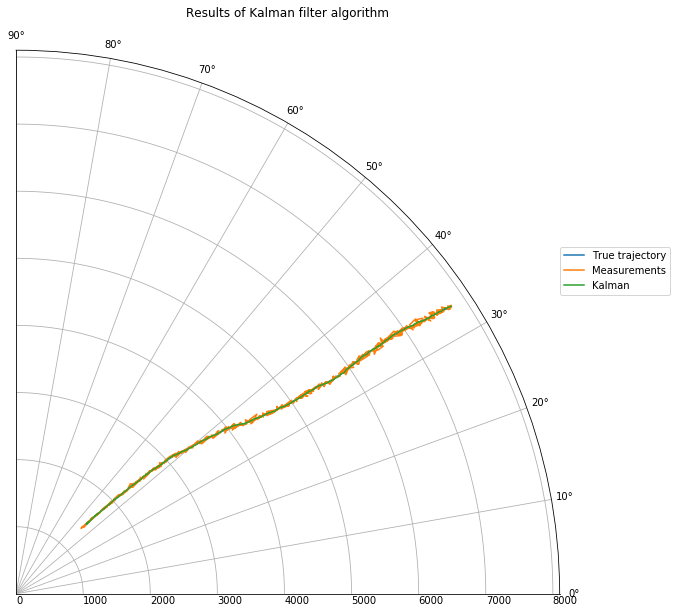

In [16]:
plt.figure(figsize=(10,10))
plt.polar(B, D)
plt.polar(B_m, D_m)
plt.polar(B_Kalman_Filter[4:], D_Kalman_Filter[4:])
plt.xlim(0,np.pi/2)
plt.title('Results of Kalman filter algorithm')
plt.legend(['True trajectory', 'Measurements', 'Kalman'], loc = (1, 0.55))
plt.show()

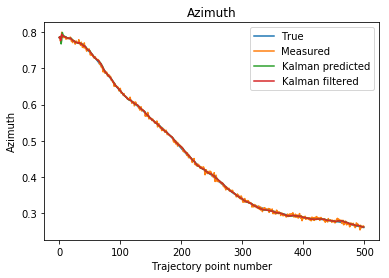

In [10]:
plt.plot(B)
plt.plot(B_m)
plt.plot(B_Kalman_Predict)
plt.plot(B_Kalman_Filter)
plt.xlabel('Trajectory point number')
plt.ylabel('Azimuth')
plt.title('Azimuth')
plt.legend(['True', 'Measured', 'Kalman predicted', 'Kalman filtered'], loc = 'best')
plt.show()

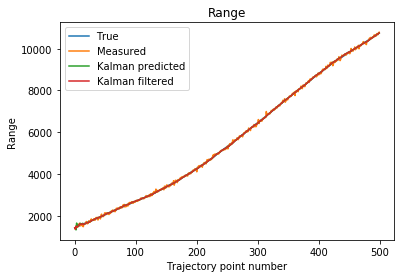

In [11]:
plt.plot(D)
plt.plot(D_m)
plt.plot(D_Kalman_Predict)
plt.plot(D_Kalman_Filter)
plt.xlabel('Trajectory point number')
plt.ylabel('Range')
plt.title('Range')
plt.legend(['True', 'Measured', 'Kalman predicted', 'Kalman filtered'], loc = 'best')
plt.show()

In [12]:
# M is the total number of runs
M=500
Errors_prediction_squared_D = np.zeros((M, N))
Errors_filtration_squared_D = np.zeros((M, N))
Errors_prediction_squared_B = np.zeros((M, N))
Errors_filtration_squared_B = np.zeros((M, N))

for j in range(M):

    #N is the size of trajectory
    N = 500

    #T is the interval between measurements
    T = 1

    #Noise of acceleration
    sigma_a = 0.3
    a_x = np.random.normal(loc=0.0, scale=sigma_a, size=N)
    a_y = np.random.normal(loc=0.0, scale=sigma_a, size=N)

    #Now let's create the trajectory
    x = np.zeros(N)
    x[0] = 1000

    y = np.zeros(N)
    y[0] = 1000

    v_x = np.zeros(N)
    v_x[0] = 10

    v_y = np.zeros(N)
    v_y[0] = 10

    for i in range(1,N):
        x[i] = x[i-1] + v_x[i-1]*T + a_x[i-1]*(T**2)/2
        v_x[i] = v_x[i-1] + a_x[i-1]*T
        y[i] = y[i-1] + v_y[i-1]*T + a_y[i-1]*(T**2)/2
        v_y[i] = v_y[i-1] + a_y[i-1]*T
        

    D = np.zeros(N)
    B = np.zeros(N)

    for i in range(N):
        D[i] = np.sqrt(x[i]**2 + y[i]**2)
        B[i] = np.arctan(x[i] / y[i])

    #noise of D
    sigma_eta_D = 50
    eta_D = np.random.normal(loc=0.0, scale=sigma_eta_D, size=N)

    #noise of beta
    sigma_eta_B = 0.004
    eta_B = np.random.normal(loc=0.0, scale=sigma_eta_B, size=N)

    #Now let's generate measurements
    D_m = np.zeros(N)
    B_m = np.zeros(N)

    for i in range(N):
        D_m[i] = D[i] + eta_D[i]
        B_m[i] = B[i] + eta_B[i]

    #Making state vector
    X = np.zeros((N, 4, 1))
    for i in range(N):
        X[i] = np.matrix([[x[i]],
                          [v_x[i]],
                          [y[i]],
                          [v_y[i]]])
    #Initial state vector
    X[0] = np.matrix([[D_m[0] * np.sin(B_m[0])],
                      [0],
                      [D_m[0] * np.cos(B_m[0])],
                      [0]])

    #Making filtration error covariance matrix P
    P = np.zeros((N, 4, 4))
    for i in range(N):
        P[i] = np.matrix([[0, 0, 0, 0],
                          [0, 0, 0, 0],
                          [0, 0, 0, 0],
                          [0, 0, 0, 0]])
    #Initial filtration error covariance matrix
    P[0] = np.matrix([[10**10, 0, 0, 0],
                      [0, 10**10, 0, 0],
                      [0, 0, 10**10, 0],
                      [0, 0, 0, 10**10]])

    #Making a transition matrix
    PHI = np.matrix([[1, T, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, T],
                     [0, 0, 0, 1]])

    #Making an input matrix
    G = np.matrix([[0.5 * T**2, 0],
               [T, 0],
               [0, 0.5 * T**2],
               [0, T]])

    #Calculating state noise covariance matrix Q
    Q = G @ G.T * sigma_a**2

    #Making measurement error covariance matrix R
    R = np.matrix([[sigma_eta_D**2, 0], 
                   [0, sigma_eta_B**2]])

    #Making measurement vector z
    z = np.zeros((N, 2, 1))
    for i in range(N):
        z[i] = np.matrix([[D_m[i]], 
                          [B_m[i]]])
        
    # Let's start Kalman filter algorithm
    D_Kalman_Predict = np.zeros(N)
    B_Kalman_Predict = np.zeros(N)
    D_Kalman_Filter = np.zeros(N)
    B_Kalman_Filter = np.zeros(N)
    D_Kalman_Predict[0] = D_m[0]
    B_Kalman_Predict[0] = B_m[0]
    D_Kalman_Filter[0] = D_m[0]
    B_Kalman_Filter[0] = B_m[0]
    dhdx = np.zeros((N, 2, 4))

    K = np.zeros((N, 4, 2))
    for i in range(N):
        K[i] = np.matrix([[0, 0, 0, 0],
                          [0, 0, 0, 0]]).T

    h = np.zeros((N, 2, 1))
    for i in range(N-1):

        #Prediction of the state vector
        X[i+1] = PHI @ X[i]
        D_Kalman_Predict[i+1] = np.sqrt(X[i+1,0]**2 + X[i+1,2]**2)
        B_Kalman_Predict[i+1] = np.arctan(X[i+1,0] / X[i+1,2])
        dhdx[i+1] = np.matrix([[np.sin(B_Kalman_Predict[i+1]), 0, np.cos(B_Kalman_Predict[i+1]), 0], [np.cos(B_Kalman_Predict[i+1]) / D_Kalman_Predict[i+1], 0, -np.sin(B_Kalman_Predict[i+1]) / D_Kalman_Predict[i+1], 0]])

        #Prediction error covariance matrix
        P[i+1] = PHI @ P[i] @ PHI.T + Q

        #Filtration
        K[i+1] = P[i+1] @ dhdx[i+1].T @ np.linalg.inv(dhdx[i+1] @ P[i+1] @ dhdx[i+1].T + R)
        h[i+1] = np.matrix([[D_Kalman_Predict[i+1]], 
                      [B_Kalman_Predict[i+1]]])
        X[i+1] = X[i+1] + K[i+1] @ (z[i+1] - h[i+1])
        D_Kalman_Filter[i+1] = np.sqrt(X[i+1,0]**2 + X[i+1,2]**2)
        B_Kalman_Filter[i+1] = np.arctan(X[i+1,0] / X[i+1,2])

        #Filtration error covariance matrix
        P[i+1] = (np.identity(np.shape(P[0])[0]) - K[i+1] @ dhdx[i+1]) @ P[i+1]

        #Errors gathering
        for i in range(3, N-1):
            Errors_prediction_squared_B[j, i] = (B_Kalman_Predict[i] - B_m[i])**2
            Errors_filtration_squared_B[j, i] = (B_Kalman_Filter[i] - B_m[i])**2
            Errors_prediction_squared_D[j, i] = (D_Kalman_Predict[i] - D_m[i])**2
            Errors_filtration_squared_D[j, i] = (D_Kalman_Filter[i] - D_m[i])**2
        

Fin_Err_prediction_squared_D = np.zeros(N)
Fin_Err_filtration_squared_D = np.zeros(N)
Fin_Err_prediction_squared_B = np.zeros(N)
Fin_Err_filtration_squared_B = np.zeros(N)
for i in range(3, N-1):
    for j in range(M):
        Fin_Err_prediction_squared_D[i] += (1/(M-1))*Errors_prediction_squared_D[j, i]
        Fin_Err_filtration_squared_D[i] += (1/(M-1))*Errors_filtration_squared_D[j, i]
        Fin_Err_prediction_squared_B[i] += (1/(M-1))*Errors_prediction_squared_B[j, i]
        Fin_Err_filtration_squared_B[i] += (1/(M-1))*Errors_filtration_squared_B[j, i]

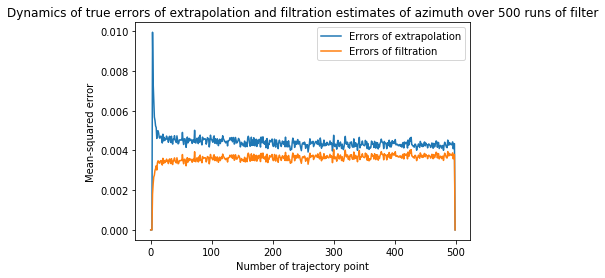

In [13]:
plt.plot(np.sqrt(Fin_Err_prediction_squared_B))
plt.plot(np.sqrt(Fin_Err_filtration_squared_B))
plt.title('Dynamics of true errors of extrapolation and filtration estimates of azimuth over 500 runs of filter')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Errors of extrapolation', 'Errors of filtration'], loc = 'best')
plt.show()

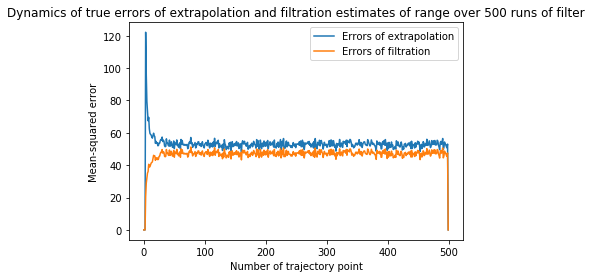

In [14]:
plt.plot(np.sqrt(Fin_Err_prediction_squared_D))
plt.plot(np.sqrt(Fin_Err_filtration_squared_D))
plt.title('Dynamics of true errors of extrapolation and filtration estimates of range over 500 runs of filter')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Errors of extrapolation', 'Errors of filtration'], loc = 'best')
plt.show()

We FINALLY learned (putting LOTS of effort into it lol) extended Kalman filter which seems to work very nicely with non-linear models